# Duration analysis

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
from config import DRIVE_PATH_VIVA, label_clustering, content_categories
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

In [4]:
# Loading raw data
general_path = os.path.join(DRIVE_PATH_VIVA, 'extracted_Education')
dir_list = os.listdir(general_path)
total_df = pd.DataFrame()
for dir in dir_list:
    batch_dir = os.path.join(general_path, dir)
    batch_df = pd.read_csv(batch_dir)
    total_df = pd.concat([total_df, batch_df])
print(len(total_df))
    
channels_df = pd.read_csv('data/raw/df_channels_en.tsv', sep = "\t")
channels_df["join_date"] = pd.to_datetime(channels_df["join_date"])

# Classified with keyword search
classified_df = pd.read_csv('data/derivatives/subcategories_18_12_w_spam.csv')

# Creating figure path 
figures_path = os.path.join('data','figures', 'duration_analysis')    
os.makedirs(figures_path, exist_ok=True)


3795564


In [5]:
total_df.head(2)

,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,0,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,A video to teach the kids to Learn the Colors ...,3.0,jCaqrZ8gSkY,116,11.0,"learn colors,kids colors,colors kids,count to ...",Learn Colors and Count to Ten with Colors Disn...,2016-05-03 00:00:00,2720.0
1,1,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.397758,Subscribe for more: https://goo.gl/JI78Ak\nNew...,1094.0,VZ6_wQxKVSI,940,2884.0,"lego city,lego police,lego,playmobil,lego robb...",Lego city police fireman bank robber boat race...,2015-06-30 00:00:00,4530589.0


### Processing

> - Print number of videos
> - Check duration
> - Get duration in minutes
> - After visualizing time distribution, 
> - Remove too small and too large videos?
> - Adding label column (classified / channel)
> - Add year channel
> - Create duration bins and add duration bin column
> - Select period
> - Add likes / dislikes / views for each videos (function in basic file)
> - Drop nans
> - Remove the keyword search for trash
> - Plot hist of duration bins



In [6]:
# Add duration in minutes for clarity
total_df['duration_in_min'] = total_df['duration']/60

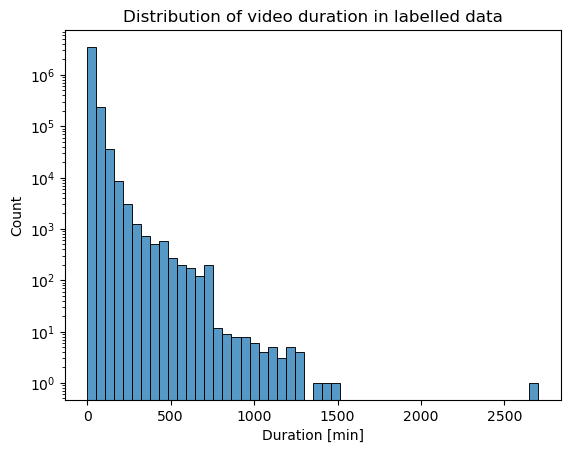

In [7]:
# Visualise the durations distribution
sns.histplot(data = total_df, x = 'duration_in_min', bins = 50)
plt.title('Distribution of video duration in labelled data')
plt.xlabel('Duration [min]')
plt.yscale('log')


(0.0, 10.0)

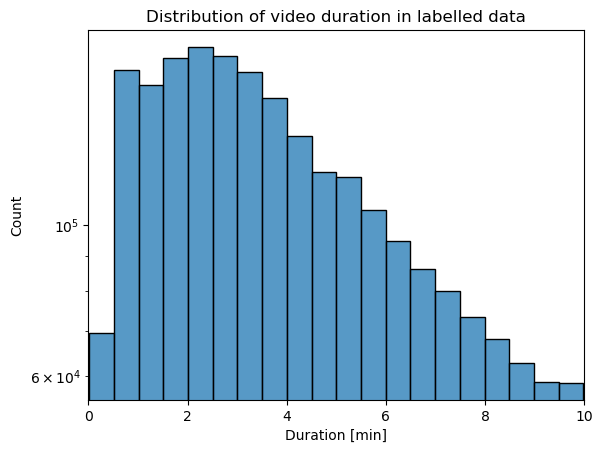

In [10]:
# Zoom on small durations
sns.histplot(data = total_df[total_df['duration_in_min']< 10], x = 'duration_in_min', bins = 20)
plt.title('Distribution of video duration in labelled data')
plt.xlabel('Duration [min]')
plt.yscale('log')


In [11]:
def find_key(category):
    for key, values in label_clustering.items():
        if category in values:
            return key
    return 'trash'

def get_metric_per_view(row, metric):
    return row[metric]/row['view_count']

In [15]:
# Select durations and view limits
min_duration = 0.5 # in minutes
max_duration = 1000
total_df = total_df[(total_df['duration_in_min'] > min_duration) & (total_df['duration_in_min'] < max_duration)]

min_views = 1000
total_df = total_df[total_df['view_count'] > min_views]

# Add duration bin column
duration_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 90, 120, float('inf')]
duration_bin_titles = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', 
                       '40-50', '50-60', '60-90', '90-120', '>120']

# Create duration_bin column
total_df['duration_bin'] = pd.cut(total_df['duration_in_min'], bins=duration_bins, labels=duration_bin_titles, right=False)


# Add label and year columns
category_ch_map = channels_df.set_index('channel')['category_cc'].to_dict()
category_lab_int_map = classified_df.set_index('display_id')['category']
classified_df['category_name'] = classified_df['category'].apply(find_key)
category_lab_str_map = classified_df.set_index('display_id')['category_name']

total_df['channel_category'] = total_df['channel_id'].map(category_ch_map)
total_df['classified_category'] = total_df['display_id'].map(category_lab_str_map)
total_df['upload_year'] = total_df['upload_date'].apply(lambda x : int(x[0:4]))

# Drop NaN + 'nan' in channel categories
total_df = total_df.dropna()
total_df = total_df[total_df['channel_category'] != 'nan']

# select time period
period = [2015, 2016, 2017, 2018]
period_data = total_df[total_df['upload_year'].isin(period)]

# Remove trash videos
period_data = period_data[period_data['classified_category'] != 'trash']

# Add metric/view
period_data['likes_per_view']= period_data.apply(lambda x: get_metric_per_view(x, 'like_count'), axis = 1)
period_data['dislikes_per_view']= period_data.apply(lambda x: get_metric_per_view(x, 'dislike_count'), axis = 1)

print(len(period_data))

377320


In [21]:
period_data.head(1)

,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,duration_in_min,channel_category,classified_category,upload_year,duration_bin,likes_per_view,dislikes_per_view
119,119,Education,UCzWBspFXaesJaWSXM27anuQ,2019-11-11 05:22:32.283250,Subscribe for 100’s of Free Drum Lessons! Drum...,2.0,LSNIXmhjrkg,354,40.0,"Drums,Drum,Drummer,Drum Lesson,Drum Lessons,Le...",Beginner Kick Groove Variation (PDF Available)...,2018-09-14 00:00:00,2603.0,5.9,Howto & Style,Music,2018,5-10,0.015367,0.000768


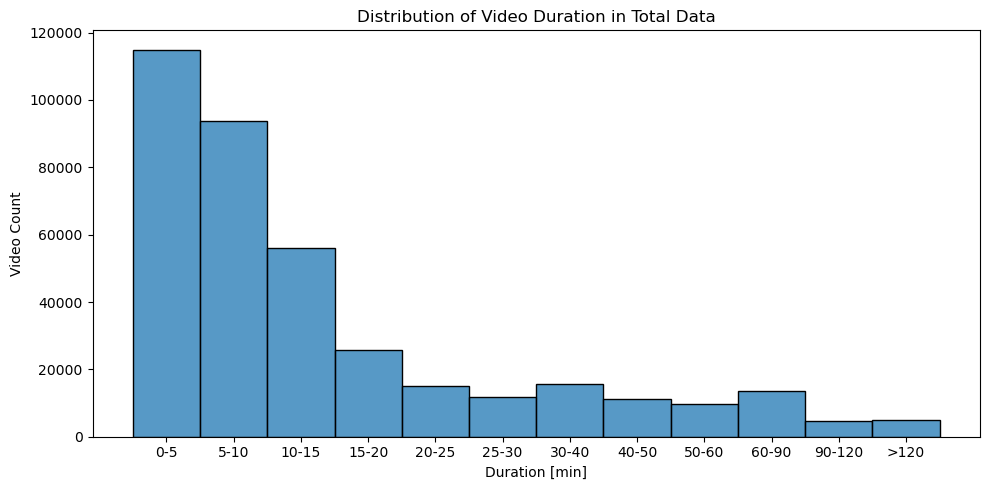

In [16]:
# Plot bin histogram
fig = plt.figure(figsize = (10, 5))
sns.histplot(data = period_data, x = 'duration_bin')
plt.title('Distribution of Video Duration in Total Data')
plt.xlabel('Duration [min]')
plt.ylabel('Video Count')
# plt.yscale('log')
# plt.ylabel('Video Count (x10^5)')
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e5:.1f}'))

plt.tight_layout()


### Visualization

> - Boxplots of duration for the selected period 
> - Boxplot for likes/view or views vs duration
> - Napoleon plots for period, then per year and category, try finding trends
> - Barplots on metrics (year, total)
> - Finer metric plots (year, total)
> - OLS plots (year, total)


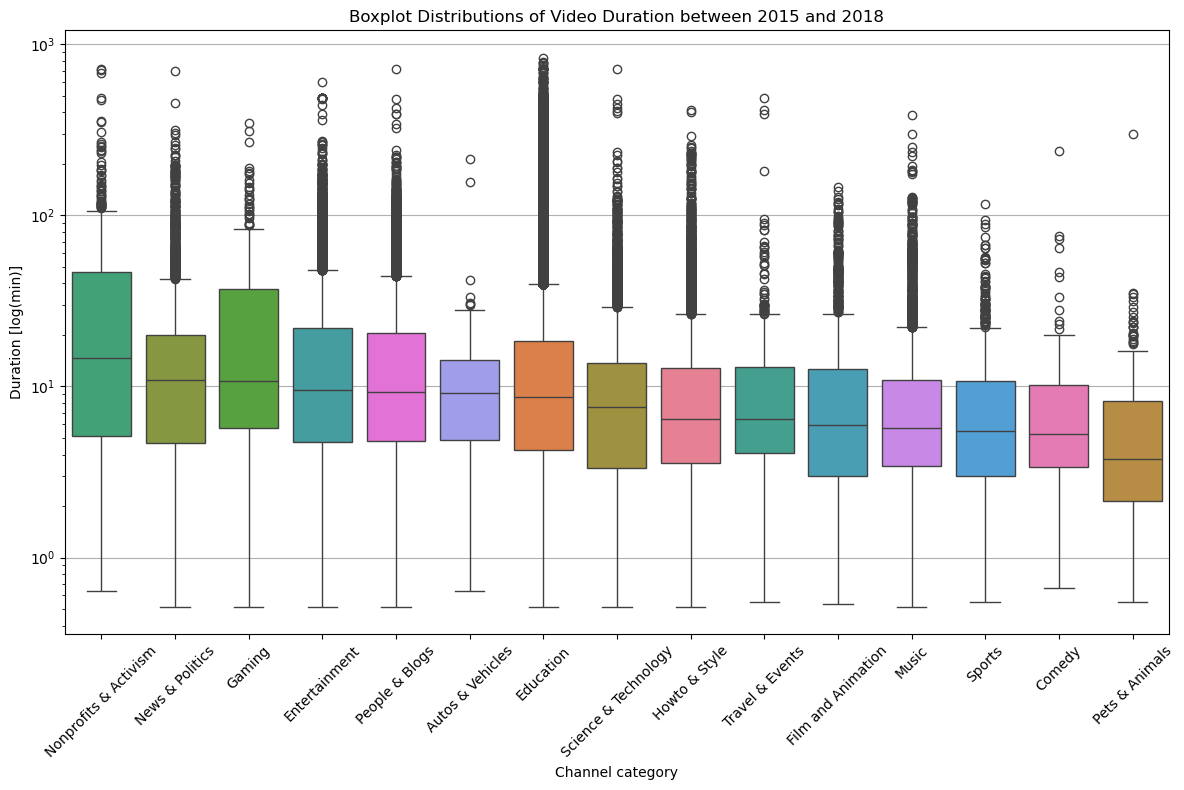

In [18]:
# Boxplots of duration for the selected period 
label_chosen = 'channel_category'

label_stats = period_data.groupby(label_chosen)['duration_in_min'].describe() # get the subjects with long context
medians = label_stats.sort_values(by='50%', ascending=False)['50%'] 

period_data[label_chosen] = period_data[label_chosen].astype(str)
medians.index = medians.index.astype(str)

fig, axs = plt.subplots(figsize=(12,8))
sns.boxplot(data=period_data, x=label_chosen, y='duration_in_min', hue =label_chosen, ax=axs, order = medians.index) # ordered by median 
plt.title(f'Boxplot Distributions of Video Duration between {period[0]} and {period[-1]}')
plt.xticks(rotation=45)
plt.xlabel('Channel category')
plt.yticks(np.arange(0, 1000, 100))
plt.ylabel('Duration [log(min)]')
plt.yscale('log')
axs.xaxis.grid(False)
axs.yaxis.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(figures_path, f'boxplot_duration_{label_chosen}'))

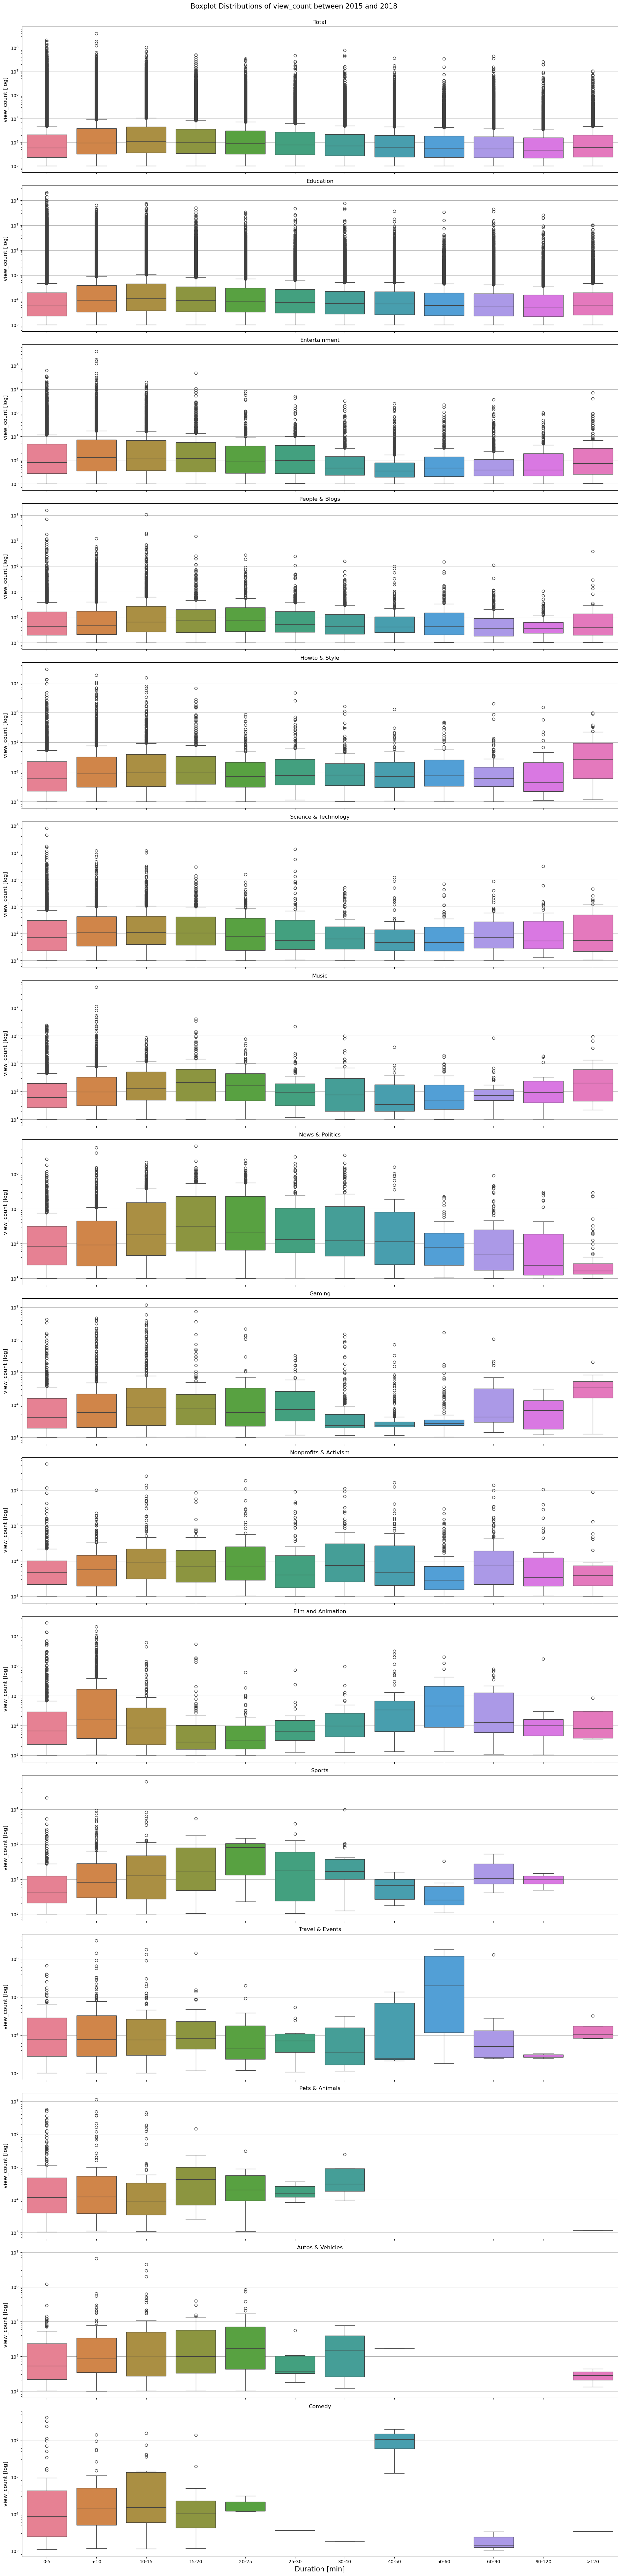

In [20]:
# Boxplot for likes/view or views vs duration

# === to solve issue of some categories not having videos long enough 
# Create a complete DataFrame with all combinations of categories and bins
categories = period_data['channel_category'].unique()
bins = period_data['duration_bin'].unique()
complete_index = pd.MultiIndex.from_product([categories, bins], names=['channel_category', 'duration_bin'])
complete_data = pd.DataFrame(index=complete_index).reset_index()

# Merge with the original data, filling missing combinations with NaN
period_data_complete = pd.merge(complete_data, period_data, on=['channel_category', 'duration_bin'], how='left')

#=======


label_chosen = 'channel_category'
metric = 'view_count' # likes_per_view, dislikes_per_view, view_count

total_labels = list(period_data[label_chosen].value_counts().index)
n_plots = len(total_labels)

fig, axs = plt.subplots(n_plots + 1, 1, figsize=(20, 80), sharex=True)

for i, ax in enumerate(axs):
    if i == 0:
        sns.boxplot(data=period_data_complete, x='duration_bin', y=metric, hue='duration_bin', ax=ax)
        ax.set_title('Total')
    else:
        sns.boxplot(data=period_data_complete[period_data_complete[label_chosen] == total_labels[i - 1]], 
                    x='duration_bin', y=metric, hue='duration_bin', ax=ax)
        ax.set_title(total_labels[i - 1])

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_yscale('log')
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e5:.1f}'))
    ax.set_ylabel(f'{metric} [log]', fontsize=12)

plt.xlabel('Duration [min]', fontsize=15)
plt.suptitle(f'Boxplot Distributions of {metric} between {period[0]} and {period[-1]}', fontsize=15)
plt.tight_layout(rect=[0.05, 0, 1, 0.98])  # adjust the layout to avoid overlapping
plt.savefig(os.path.join(figures_path, f'boxplot_{metric}_{label_chosen}'))
